In [1]:
from collections import namedtuple
import extractor
import numpy as np
import torch 
from torch.autograd import Variable
import torch.functional as F
import torch.nn.functional as F


In [2]:
data_path = 'raw.txt'
cpu = torch.device('cpu')

In [3]:
def generate_index(text):
  print("generating index")
  Word2idx = namedtuple("Word2idx",['word2idx','idx2word','sentences'])
  vocab = []
  sentence = []
  for line in text:
    tokenized_sentence = extractor.extract_gram(line,1)
    sentence.append(list(filter(lambda w: w not in extractor.erase_symbol,tokenized_sentence)))
    for each in tokenized_sentence:
      if each not in vocab and each not in extractor.erase_symbol:
        vocab.append(each)
  w2i = {w: idx for (idx,w) in enumerate(vocab)}
  i2w = {idx: w for (idx,w) in enumerate(vocab)}
  return Word2idx(w2i, i2w, sentence)

def loadStream(path):
  with open(path,mode='r',encoding='utf-8') as f:
    while f.readable():
      l = f.readline()
      if len(l) == 0:
        return
      yield str(l).strip()
def index_center_context_word(window_size:int,word2index,tokenized_sentence):
  idx_pairs = []
  for sentence in tokenized_sentence:
    indices = [word2index[word] for word in sentence] # of a sentence
    for center_word_pos in range(len(indices)):
      for cur_w in range(-window_size,window_size + 1):
        context_word_pos = center_word_pos + cur_w
        if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
            continue
        context_word_idx = indices[context_word_pos]
        idx_pairs.append((indices[center_word_pos], context_word_idx))
  return np.array(idx_pairs)


def get_input_layer(word_idx,vocab_size):
    x = torch.zeros(vocab_size).float()
    x[word_idx] = 1.0
    return x


In [4]:
idxs = generate_index(loadStream(data_path))
idx_pairs = index_center_context_word(2,idxs.word2idx,idxs.sentences)
vocab_size = len(idxs.word2idx)

generating index


In [5]:
embedding_dims = 5
W1 = Variable(torch.randn(embedding_dims, vocab_size).float(), requires_grad=True)
W2 = Variable(torch.randn(vocab_size, embedding_dims).float(), requires_grad=True)
num_epochs = 50
learning_rate = 0.001
print('ready to train')

ready to train


In [6]:
#train
for epo in range(num_epochs):
  loss_val = 0
  for data, target in idx_pairs:
      x = Variable(get_input_layer(data,vocab_size)).float()
      y_true = Variable(torch.from_numpy(np.array([target])).long())

      z1 = torch.matmul(W1, x)
      z2 = torch.matmul(W2, z1)
  
      log_softmax = F.log_softmax(z2, dim=0)

      loss = F.nll_loss(log_softmax.view(1,-1), y_true)
      loss_val += loss.data
      loss.backward()
      W1.data -= learning_rate * W1.grad.data
      W2.data -= learning_rate * W2.grad.data

      W1.grad.data.zero_()
      W2.grad.data.zero_()

  print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')


Loss at epo 0: 6.524082660675049
Loss at epo 1: 6.043858051300049
Loss at epo 2: 5.980018138885498
Loss at epo 3: 5.947444915771484
Loss at epo 4: 5.927947044372559
Loss at epo 5: 5.914925575256348
Loss at epo 6: 5.9055633544921875
Loss at epo 7: 5.898369789123535
Loss at epo 8: 5.892503261566162
Loss at epo 9: 5.887757778167725
Loss at epo 10: 5.883763790130615
Loss at epo 11: 5.880277156829834
Loss at epo 12: 5.877324104309082
Loss at epo 13: 5.874698162078857
Loss at epo 14: 5.872403621673584
Loss at epo 15: 5.870344638824463
Loss at epo 16: 5.868500709533691
Loss at epo 17: 5.866878032684326
Loss at epo 18: 5.86541223526001
Loss at epo 19: 5.8640642166137695


In [7]:
def predict(word_index):
    x = Variable(get_input_layer(word_index,vocab_size)).float()

    z1 = torch.matmul(W1, x)
    z2 = torch.matmul(W2, z1)

    return F.log_softmax(z2, dim=0)

In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_word_similarity(index_to_word: dict):
    labels = [w for w in index_to_word.values()]
    tokens = [[float(v) for v in predict(i)] for i in index_to_word.keys()]
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    print("ready to PCA")
    compressed_values = tsne_model.fit_transform(tokens)

    px = [v[0] for v in compressed_values]
    py = [v[1] for v in compressed_values]
    
    plt.figure(figsize=(100,100),dpi=80)
    font_dict = dict(
        fontsize=12,
        family='mingliu'
    )

    for i in range(len(px)):
        plt.plot(px[i],py[i],'rx')
        plt.text(px[i],py[i],labels[i],fontdict=font_dict)

ready to PCA


C:\Users\HDIT3\.conda\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\HDIT3\.conda\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\HDIT3\.conda\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\HDIT3\.conda\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 162208 (\N{CJK UNIFIED IDEOGRAPH-279A0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\HDIT3\.conda\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 167114 (\N{CJK UNIFIED IDEOGRAPH-28CCA

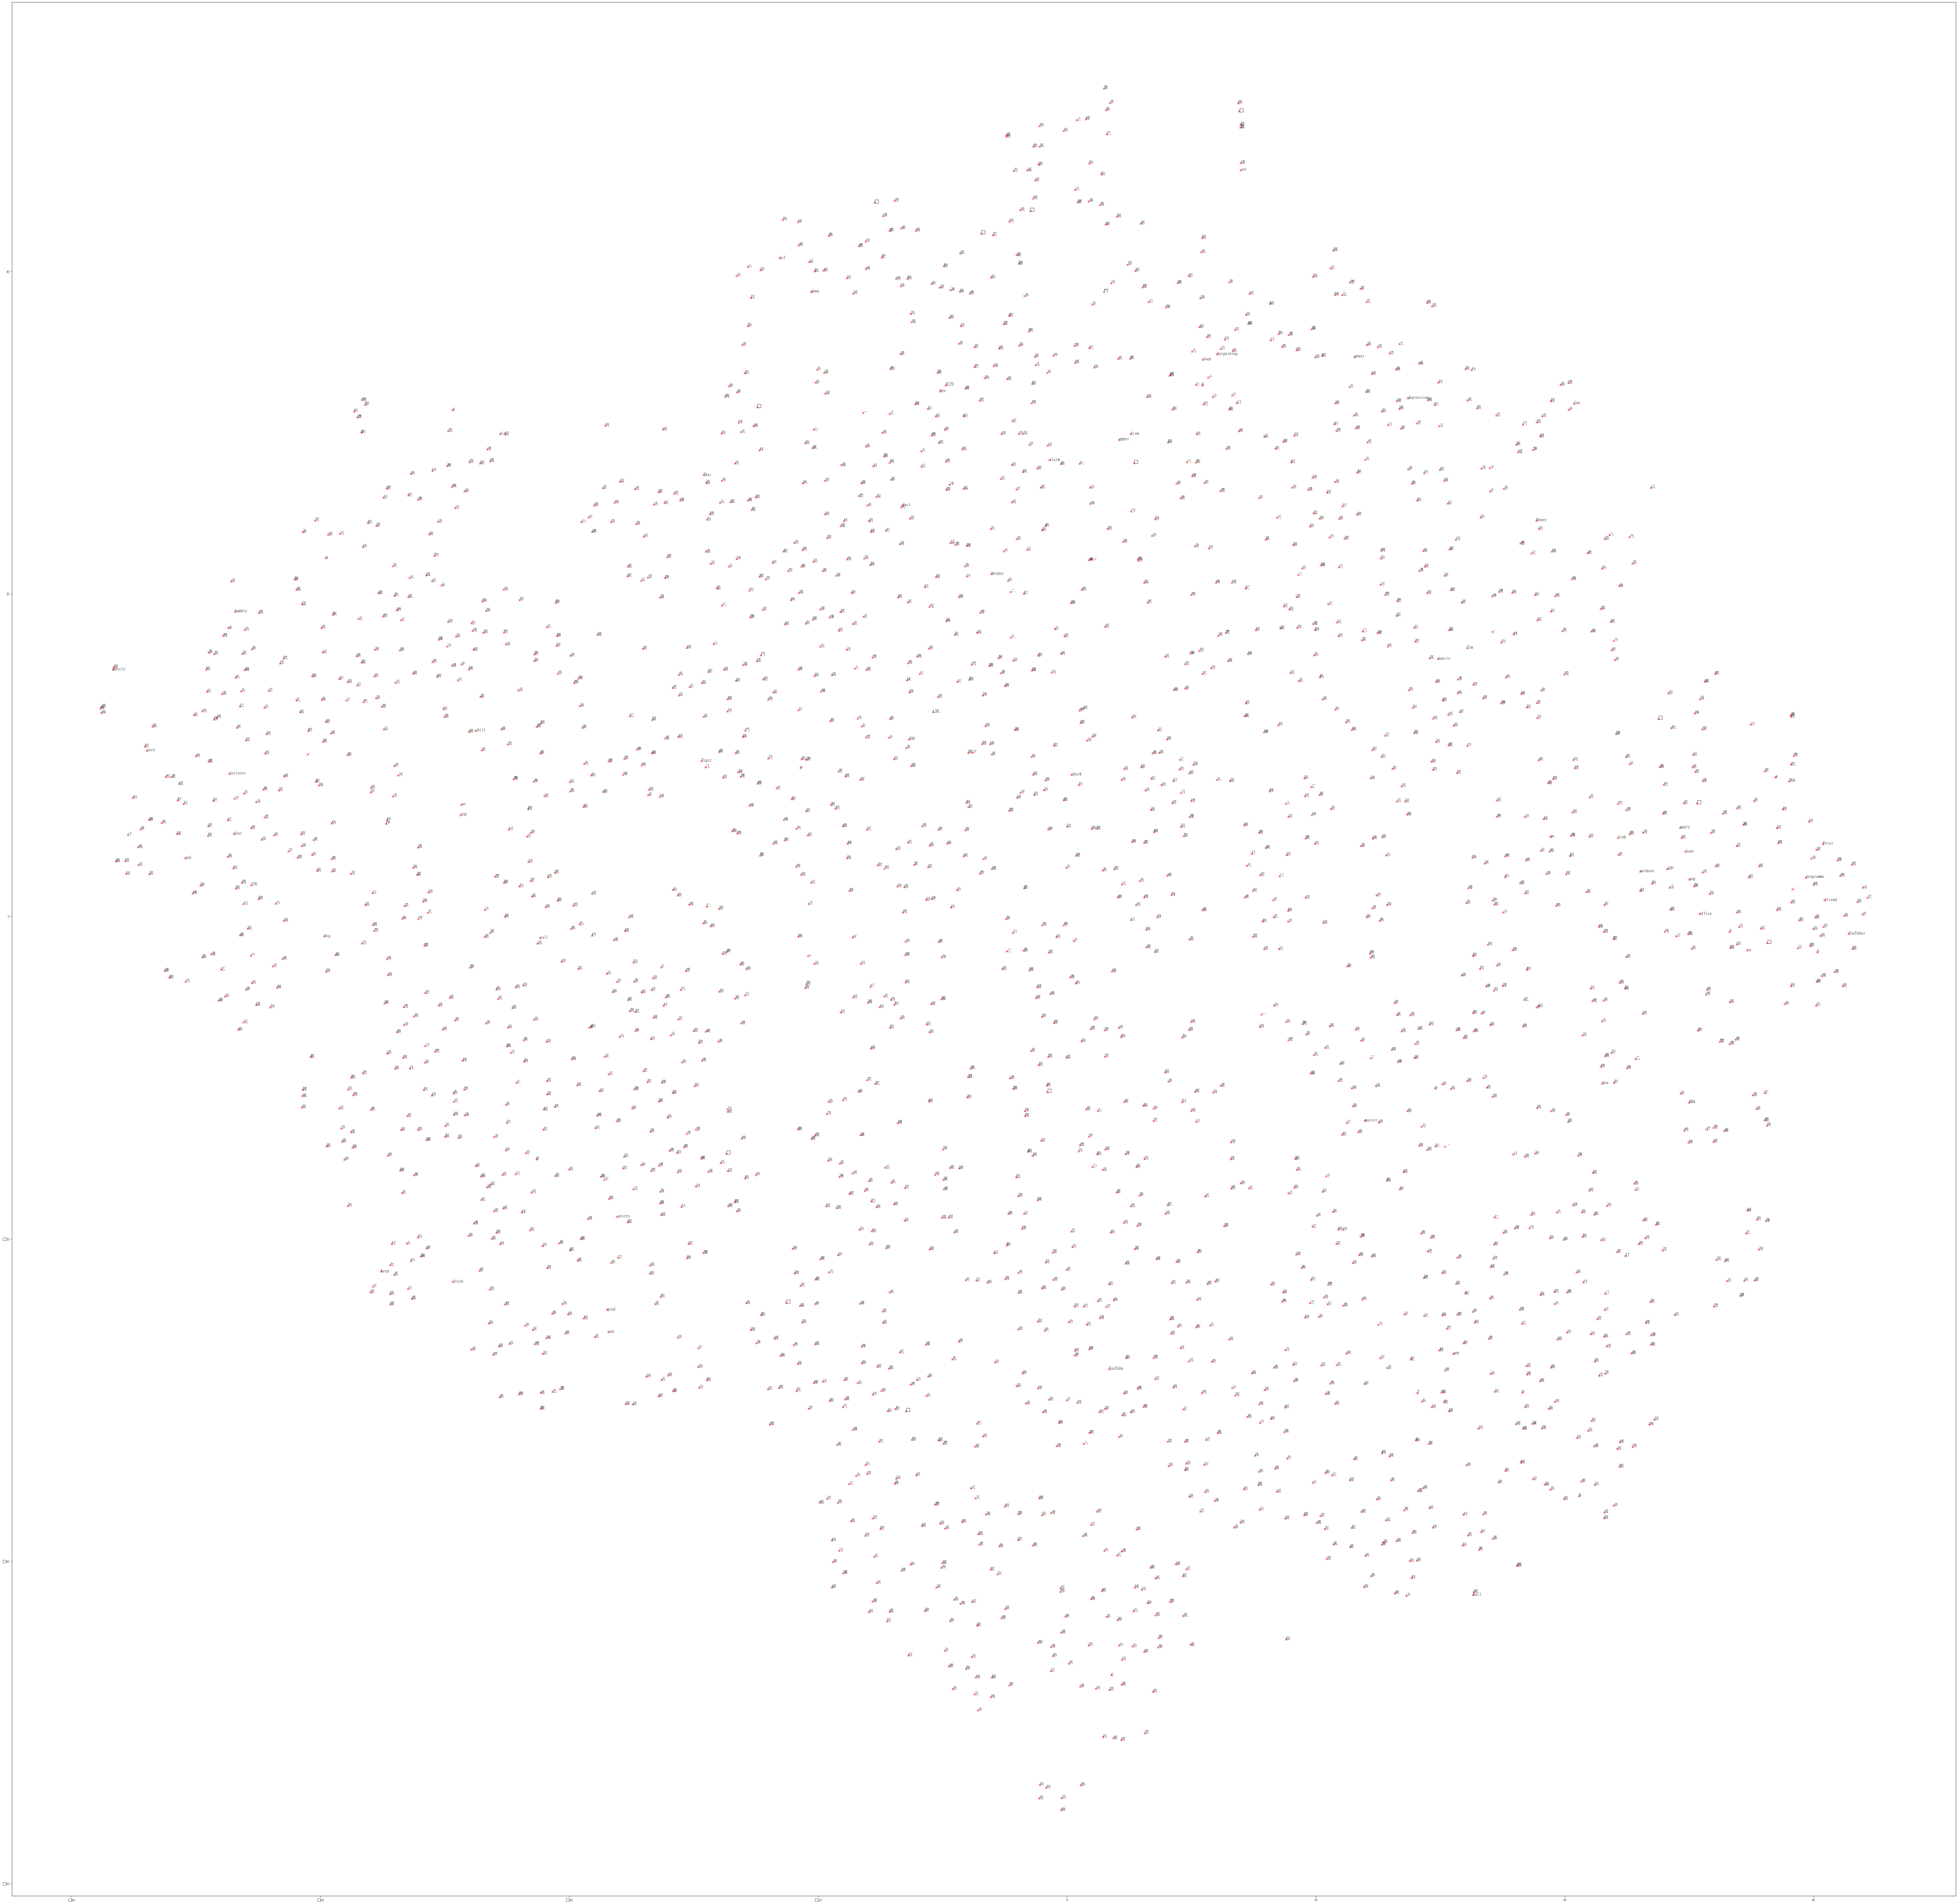

In [11]:
# cnt = 0
# i2w = {}
# for k in idxs.idx2word.keys():
#     cnt += 1
#     if cnt == 1500:
#         break
#     i2w[k] = idxs.idx2word[k]

# plot_word_similarity(idxs.idx2word)

In [12]:
result = predict(idxs.word2idx['屌'])
close = {idxs.idx2word[i]:weight for (i,weight) in enumerate(result)}
sorted(close,key=close.get,reverse=True)[:15]

['係', '你', '真', '…', '個', '我', '唔', '嘅', '都', '好', '啦', '屌', '話', '有', '撚']